In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics
import requests

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

pd.plotting.register_matplotlib_converters()

In [2]:
#labeling column names for the txt file that will be brought in
colnames=['date','time','page_viewed','user_id','cohort_id','ip']

#bringing in the txt file
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames, #will be labeling the the columns the names above
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,1,2,3,4,5]) #only using these specified columns

df

,date,time,page_viewed,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175


In [3]:
colnames=['cohort_id','name','start_date','end_date','program_id']
df_cohort = pd.read_csv('cohorts.csv',
                       names=colnames, 
                       skiprows=1,
                       usecols=[0,1,2,3,4])
#print(df_cohort.info())
df_cohort

,cohort_id,name,start_date,end_date,program_id
0,1,Arches,2014-02-04,2014-04-22,1
1,2,Badlands,2014-06-04,2014-08-22,1
2,3,Carlsbad,2014-09-04,2014-11-05,1
3,4,Denali,2014-10-20,2015-01-18,1
4,5,Everglades,2014-11-18,2015-02-24,1
5,6,Franklin,2015-02-03,2015-05-26,1
6,7,Glacier,2015-06-05,2015-10-06,1
7,8,Hampton,2015-09-22,2016-02-06,1
8,9,Apollo,2015-03-30,2015-07-29,4
9,10,Balboa,2015-11-03,2016-03-11,4


In [4]:
df = df.merge(df_cohort, on='cohort_id', how='left')
df.head()

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


### How many nulls do we have?

In [5]:
df.user_id.isna().sum()

0

In [6]:
df.cohort_id.isna().sum()

44840

### Quite a bit of nulls, Lets break it down by cohort

In [7]:
len(df.cohort_id.value_counts())

40

In [8]:
len(df_cohort.cohort_id.value_counts())

46

### We have 6 cohorts missing, which ones are they?

In [9]:
#cohorts = pd.DataFrame(columns = [df.cohort_id, df_cohort.cohort_id])

dfc= df_cohort.cohort_id.value_counts().index
dfco = df.cohort_id.value_counts().index

print('The missing cohorts are: ', set(dfc) - set(dfco))
df_cohort.loc[(df_cohort['cohort_id'] == 3)|(df_cohort['cohort_id'] == 132)|(df_cohort['cohort_id'] == 10)|(df_cohort['cohort_id'] == 20)|(df_cohort['cohort_id'] == 60)|(df_cohort['cohort_id'] == 30)]


The missing cohorts are:  {3, 132, 10, 20, 60, 30}


,cohort_id,name,start_date,end_date,program_id
2,3,Carlsbad,2014-09-04,2014-11-05,1
9,10,Balboa,2015-11-03,2016-03-11,4
19,20,Redwood,2017-07-31,2017-12-06,2
29,30,Ada,2019-02-04,2019-06-16,3
42,60,Io,2020-07-20,2021-01-21,2
45,132,Kalypso,2020-11-02,2021-05-04,2


### Lets create 2 different dataframes for the null values and non null values

In [10]:
df2 = df[df.cohort_id.isna()]
df2.cohort_id.fillna(0, inplace=True)
df2

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
411,2018-01-26,16:46:16,/,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
425,2018-01-26,17:54:24,/,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
435,2018-01-26,18:32:03,/,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
436,2018-01-26,18:32:17,mysql/relationships/joins,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
719411,2020-11-02,16:02:22,java-iii,717,0.0,136.50.18.157,NaN,NaN,NaN,NaN
719412,2020-11-02,16:02:26,java-iii/servlets,717,0.0,136.50.18.157,NaN,NaN,NaN,NaN
719414,2020-11-02,16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,0.0,70.94.165.107,NaN,NaN,NaN,NaN
719416,2020-11-02,16:04:18,java-iii/servlets,727,0.0,70.94.165.107,NaN,NaN,NaN,NaN


In [11]:
df = df.dropna()
df

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0


### From here, lets break it down from web dev to DS

In [12]:
df.program_id.value_counts()

2.0    576508
3.0     68016
1.0     30089
4.0         5
Name: program_id, dtype: int64

In [13]:
df[df['program_id'] == 1]

# Program 1 seems to be Web Dev

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
30,2018-01-26,10:14:47,/,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
...,...,...,...,...,...,...,...,...,...,...
668987,2020-09-13,14:43:04,content/php_iv/exceptions/try-catch.html,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0
668988,2020-09-13,14:43:10,content/php_iv/classes-and-objects-ii,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0
668989,2020-09-13,14:43:12,content/php_iv/classes-and-objects-ii/visibili...,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0
668990,2020-09-13,14:43:38,content/php_iv/classes-and-objects-ii/magic-me...,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0


In [14]:
df[df['program_id'] == 2]

# Program 2 seems to be Web Dev

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0


In [15]:
df[df['program_id'] == 3]

# Program 3 seems to be Data Science

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
326053,2019-08-20,09:39:58,/,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326054,2019-08-20,09:39:59,/,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326055,2019-08-20,09:39:59,/,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326056,2019-08-20,09:40:02,/,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326057,2019-08-20,09:40:08,/,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
...,...,...,...,...,...,...,...,...,...,...
719391,2020-11-02,15:50:07,appendix/open_data,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719396,2020-11-02,15:52:23,timeseries/sarimax,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719400,2020-11-02,15:57:22,/,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0
719401,2020-11-02,15:57:25,search/search_index.json,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0


In [16]:
df[df['program_id'] == 4]

# Program 4 looks to be Web Dev

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
31627,2018-03-22,19:01:49,/,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31628,2018-03-22,19:01:54,content/html-css,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31629,2018-03-22,19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31630,2018-03-22,19:02:47,content/html-css,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31631,2018-03-22,19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0


In [17]:
# We'll group up the program Id's into Dataframes for better exploration

df_ds = df[df['program_id'] == 3]
df_ds


,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
326053,2019-08-20,09:39:58,/,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326054,2019-08-20,09:39:59,/,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326055,2019-08-20,09:39:59,/,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326056,2019-08-20,09:40:02,/,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326057,2019-08-20,09:40:08,/,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
...,...,...,...,...,...,...,...,...,...,...
719391,2020-11-02,15:50:07,appendix/open_data,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719396,2020-11-02,15:52:23,timeseries/sarimax,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719400,2020-11-02,15:57:22,/,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0
719401,2020-11-02,15:57:25,search/search_index.json,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0


In [18]:
df_wd = df[df['program_id'] != 3]
df_wd

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0


In [19]:
# How many cohorts are there in each dataframe?

df_ds['cohort_id'].value_counts()

34.0    25181
59.0    22425
55.0    20410
Name: cohort_id, dtype: int64

In [20]:
df_wd['cohort_id'].value_counts()

28.0    60315
33.0    40168
29.0    37548
53.0    36047
24.0    35624
57.0    32447
56.0    31670
22.0    30328
51.0    29688
58.0    28354
32.0    28333
23.0    28329
26.0    27637
52.0    27518
25.0    25427
31.0    25253
27.0    20447
61.0    11774
14.0     9495
1.0      8884
62.0     8718
21.0     7444
17.0     4925
13.0     2733
18.0     2005
8.0      1712
19.0     1165
16.0      743
15.0      691
7.0       495
12.0      302
11.0      208
2.0        93
6.0        72
9.0         5
4.0         4
5.0         1
Name: cohort_id, dtype: int64

# <div class="alert alert-block alert-info">1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?</div>

### -A majority of the Data Science Cohorts tend to hit ```1-fundamentals/1.1-intro-to-data-science```

### -Webdev cohorts tend to hit the ```javascript-i``` page

In [21]:
# Turning the forward slash to home

df_ds.replace('/', 'home', inplace=True)
df_wd.replace('/', 'home', inplace=True)


In [22]:
df_ds.page_viewed.value_counts().head(20)

home                                                 5406
1-fundamentals/modern-data-scientist.jpg             1563
1-fundamentals/AI-ML-DL-timeline.jpg                 1559
1-fundamentals/1.1-intro-to-data-science             1536
search/search_index.json                             1331
6-regression/1-overview                              1123
classification/overview                               860
10-anomaly-detection/AnomalyDetectionCartoon.jpeg     745
10-anomaly-detection/1-overview                       742
3-sql/1-mysql-overview                                704
1-fundamentals/DataToAction_v2.jpg                    662
classification/scale_features_or_not.svg              642
1-fundamentals/1.2-data-science-pipeline              638
sql/mysql-overview                                    615
appendix/cli-git-overview                             579
5-stats/4.2-compare-means                             554
5-stats/3-probability-distributions                   525
3-sql/7-functi

In [23]:
df_wd.page_viewed.value_counts().head(20)

home                                                                         30669
javascript-i                                                                 13902
toc                                                                          13404
search/search_index.json                                                     12271
java-iii                                                                     10610
html-css                                                                     10363
java-ii                                                                       9956
spring                                                                        9699
jquery                                                                        8846
mysql                                                                         8774
java-i                                                                        8699
javascript-ii                                                                 8367
appe

#  <div class="alert alert-block alert-info">2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?</div>

### - The Data Science Darden cohort had significant hits on the ```classification/overview``` page compared to the other cohorts.

### - In Web Dev, there is not a cohort that has hit a page significantly more than other cohorts. The largest Variation in page hits is the Ceres cohort viewing the ```javascript-i``` 93 times more than next highest views which was done by the Voyageurs cohort.

In [24]:
### Data Science ###

In [25]:
df_ds.page_viewed.value_counts().head(30)

home                                                 5406
1-fundamentals/modern-data-scientist.jpg             1563
1-fundamentals/AI-ML-DL-timeline.jpg                 1559
1-fundamentals/1.1-intro-to-data-science             1536
search/search_index.json                             1331
6-regression/1-overview                              1123
classification/overview                               860
10-anomaly-detection/AnomalyDetectionCartoon.jpeg     745
10-anomaly-detection/1-overview                       742
3-sql/1-mysql-overview                                704
1-fundamentals/DataToAction_v2.jpg                    662
classification/scale_features_or_not.svg              642
1-fundamentals/1.2-data-science-pipeline              638
sql/mysql-overview                                    615
appendix/cli-git-overview                             579
5-stats/4.2-compare-means                             554
5-stats/3-probability-distributions                   525
3-sql/7-functi

In [26]:
# Getting the top ten lessons viewed ready to be graphed

dsl = df_ds[(df_ds.page_viewed == '1-fundamentals/1.1-intro-to-data-science')\
            |(df_ds.page_viewed == '6-regression/1-overview')\
            |(df_ds.page_viewed == 'classification/overview')\
            |(df_ds.page_viewed == '10-anomaly-detection/1-overview')\
            |(df_ds.page_viewed == '1-fundamentals/1.2-data-science-pipeline')\
            |(df_ds.page_viewed == 'sql/mysql-overview')\
            |(df_ds.page_viewed == '3-sql/1-mysql-overview')]


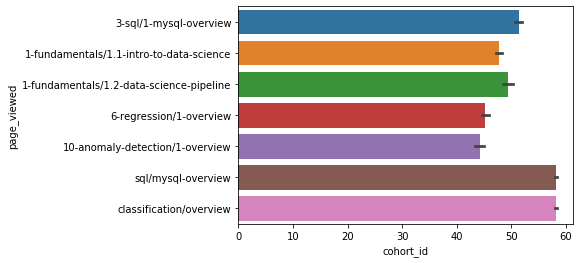

In [27]:
sns.barplot(x=dsl.cohort_id, y=dsl.page_viewed)

#sns.barplot(x=dsl.page_viewed, y=dsl.cohort_id)

In [28]:
dsl1 = pd.crosstab(dsl.cohort_id, dsl.page_viewed)
dsl1

page_viewed,1-fundamentals/1.1-intro-to-data-science,1-fundamentals/1.2-data-science-pipeline,10-anomaly-detection/1-overview,3-sql/1-mysql-overview,6-regression/1-overview,classification/overview,sql/mysql-overview
cohort_id,,,,,,,
34.0,615,221,383,142,521,10,3
55.0,461,146,345,441,595,91,99
59.0,460,271,14,121,7,759,513


In [29]:
dsl1.apply(lambda col: col.nlargest(2))
#(df['Gold'] - df['Gold.1']).idxmax()
#dsl1['max_value'] = dsl1.max()
#wsl1['second_value'] = wsl1.nLargest(2)(axis=1)

#dsl1['hit_diff'] = dsl1.max_value - dsl1.second_value
#dsl1

page_viewed,1-fundamentals/1.1-intro-to-data-science,1-fundamentals/1.2-data-science-pipeline,10-anomaly-detection/1-overview,3-sql/1-mysql-overview,6-regression/1-overview,classification/overview,sql/mysql-overview
cohort_id,,,,,,,
34.0,615.0,221.0,383.0,142.0,521.0,NaN,NaN
55.0,461.0,NaN,345.0,441.0,595.0,91.0,99.0
59.0,NaN,271.0,NaN,NaN,NaN,759.0,513.0


In [30]:
### Web Dev ###

In [31]:
df_wd.page_viewed.value_counts().head(30)

home                                                                         30669
javascript-i                                                                 13902
toc                                                                          13404
search/search_index.json                                                     12271
java-iii                                                                     10610
html-css                                                                     10363
java-ii                                                                       9956
spring                                                                        9699
jquery                                                                        8846
mysql                                                                         8774
java-i                                                                        8699
javascript-ii                                                                 8367
appe

In [32]:
wsl = df_wd[(df_wd.page_viewed == 'javascript-i')\
            |(df_wd.page_viewed == 'java-iii')\
            |(df_wd.page_viewed == 'spring')\
            |(df_wd.page_viewed == 'jquery')\
            |(df_wd.page_viewed == 'javascript-ii')\
            |(df_wd.page_viewed == 'java-i')\
            |(df_wd.page_viewed == 'mysql')]

In [33]:
#sns.factorplot(x='cohort_id', y='page_viewed', data=dsl, kind='bar')

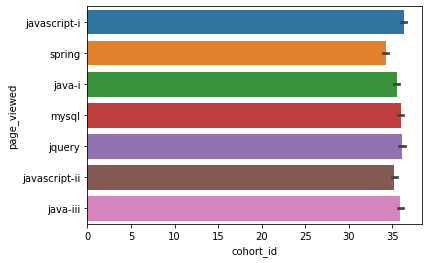

In [34]:
sns.barplot(x=wsl.cohort_id, y=wsl.page_viewed)

In [35]:
wsl1 = pd.crosstab(wsl.cohort_id, wsl.page_viewed)
wsl1.drop(28, inplace=True)
wsl1

page_viewed,java-i,java-iii,javascript-i,javascript-ii,jquery,mysql,spring
cohort_id,,,,,,,
1.0,132,153,294,204,133,95,192
2.0,1,0,1,0,0,0,0
6.0,3,3,2,2,2,2,2
7.0,8,0,11,6,3,2,2
8.0,46,57,36,31,26,30,43
11.0,5,5,7,4,4,4,5
12.0,1,1,1,0,0,0,0
13.0,20,8,17,10,2,5,3
14.0,138,224,233,107,102,105,222


In [36]:
wsl1.apply(lambda col: col.nlargest(2))

page_viewed,java-i,java-iii,javascript-i,javascript-ii,jquery,mysql,spring
cohort_id,,,,,,,
22.0,NaN,NaN,NaN,NaN,NaN,631.0,707.0
24.0,639.0,770.0,884.0,584.0,583.0,663.0,650.0
29.0,593.0,NaN,NaN,637.0,NaN,NaN,NaN
33.0,NaN,NaN,977.0,NaN,632.0,NaN,NaN
53.0,NaN,767.0,NaN,NaN,NaN,NaN,NaN


In [37]:

wsl1['second_value'] = wsl1.apply(lambda row: row.nlargest(2).values[-1],axis=1)
#(df['Gold'] - df['Gold.1']).idxmax()
wsl1['max_value'] = wsl1.max(axis=1)
#wsl1['second_value'] = wsl1.nLargest(2)(axis=1)

wsl1['hit_diff'] = wsl1.max_value - wsl1.second_value
wsl1

page_viewed,java-i,java-iii,javascript-i,javascript-ii,jquery,mysql,spring,second_value,max_value,hit_diff
cohort_id,,,,,,,,,,
1.0,132,153,294,204,133,95,192,204,294,90
2.0,1,0,1,0,0,0,0,1,1,0
6.0,3,3,2,2,2,2,2,3,3,0
7.0,8,0,11,6,3,2,2,8,11,3
8.0,46,57,36,31,26,30,43,46,57,11
11.0,5,5,7,4,4,4,5,5,7,2
12.0,1,1,1,0,0,0,0,1,1,0
13.0,20,8,17,10,2,5,3,17,20,3
14.0,138,224,233,107,102,105,222,224,233,9


 # <div class="alert alert-block alert-info">3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?</div>

### Data Science
### User 679:
- From the Darden cohort, accessed curriculum on first 2 days of class
- User id changed from 679 to 698 then accessed curriculum for an additional day and hasnt been active on the site.

### User 487:
- From the Bayes Cohort, only accessed the curriculum for one day.

### User 684:
- From the Darden cohort, user id was changed from 684 to 783

### User 689
- From the Darden cohort, user id was changed from 689 to 785

----------------------------------------------------------

### Web Dev

### User 388:
- From the Andromedes cohort, is only active on the 2nd day of class.

### User 619
- From the Ganymede cohort, was only active on the first day of class

<Figure size 936x504 with 0 Axes>

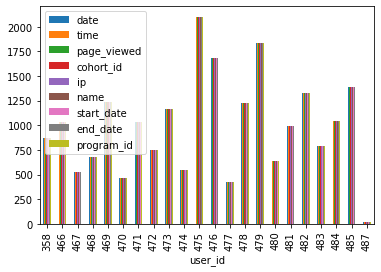

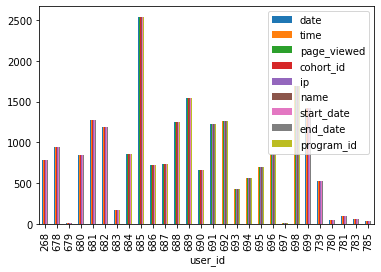

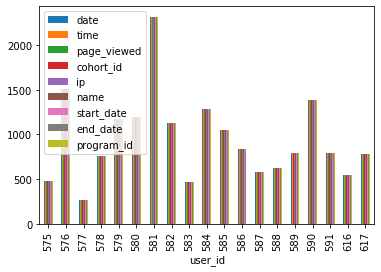

In [38]:
cohorts = [34, 59, 55]
plt.figure(figsize=(13,7))
for p in cohorts:
    ds1 = df_ds[df_ds.cohort_id == p]
    ds1[ds1.date.between(ds1.start_date, ds1.end_date, inclusive = True)].groupby('user_id').count().plot(kind='bar')
    plt.show()

In [39]:
df_ds.groupby('user_id')['page_viewed'].nunique().sort_values().head(20)

user_id
787      1
746      1
679      5
650      6
487      9
697     10
783     13
785     14
781     21
780     24
683     47
739     76
577     81
587     99
693    109
686    127
690    132
694    132
678    134
470    134
Name: page_viewed, dtype: int64

In [40]:
df_ds[df_ds.user_id == 739] 

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
632295,2020-08-07,19:17:51,python/intro-to-matplotlib,739,59.0,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0
632296,2020-08-07,19:17:56,home,739,59.0,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0
632297,2020-08-07,19:18:16,fundamentals/git,739,59.0,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0
632299,2020-08-07,19:29:05,python/intro-to-numpy,739,59.0,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0
634072,2020-08-10,11:22:19,python/intro-to-numpy,739,59.0,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0
...,...,...,...,...,...,...,...,...,...,...
705816,2020-10-20,13:32:10,clustering/model,739,59.0,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0
705999,2020-10-20,14:45:47,clustering/explore,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0
706000,2020-10-20,14:45:48,clustering/explore,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0
706011,2020-10-20,14:58:07,clustering/model,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0


In [41]:
df_ds[df_ds.ip == '107.77.219.35']

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
705999,2020-10-20,14:45:47,clustering/explore,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0
706000,2020-10-20,14:45:48,clustering/explore,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0
706011,2020-10-20,14:58:07,clustering/model,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0
706063,2020-10-20,15:27:16,classification/logistic-regression,739,59.0,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0


In [42]:
df_ds[df_ds.user_id == 787] 

## Was not an active student

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
716197,2020-10-29,22:08:03,appendix/interview_questions_students,787,55.0,99.126.113.140,Curie,2020-02-03,2020-07-07,3.0


In [43]:
df_ds[df_ds.user_id == 746]

## Was not an Active Student

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
665735,2020-09-10,10:50:28,home,746,55.0,173.175.100.201,Curie,2020-02-03,2020-07-07,3.0


In [44]:
df_ds[df_ds.user_id == 679] 

## Only accessed curriculum first and 2nd day of class

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
597043,2020-07-13,14:37:22,home,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597057,2020-07-13,14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597058,2020-07-13,14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597059,2020-07-13,14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597060,2020-07-13,14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597341,2020-07-13,15:49:31,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597342,2020-07-13,15:49:32,1-fundamentals/modern-data-scientist.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597343,2020-07-13,15:49:32,1-fundamentals/AI-ML-DL-timeline.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597685,2020-07-14,08:05:15,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597686,2020-07-14,08:05:15,1-fundamentals/AI-ML-DL-timeline.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0


In [45]:
df_ds[df_ds.ip == '24.28.146.155']

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
597043,2020-07-13,14:37:22,home,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597057,2020-07-13,14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597058,2020-07-13,14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597059,2020-07-13,14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
597060,2020-07-13,14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
...,...,...,...,...,...,...,...,...,...,...
600023,2020-07-15,17:47:18,1-fundamentals/AI-ML-DL-timeline.jpg,698,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
600024,2020-07-15,17:47:18,1-fundamentals/modern-data-scientist.jpg,698,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
600025,2020-07-15,17:47:35,1-fundamentals/1.2-data-science-pipeline,698,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0
600026,2020-07-15,17:47:36,1-fundamentals/DataToAction_v2.jpg,698,59.0,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0


In [46]:
df_ds[df_ds.user_id == 650] 

## Was not an active student

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
535938,2020-05-07,10:35:25,home,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
535941,2020-05-07,10:35:52,appendix/professional-development/virtual-meet...,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
583490,2020-06-25,10:18:26,home,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
583491,2020-06-25,10:19:01,appendix/cli-git-overview,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
583492,2020-06-25,10:20:00,appendix/ds-environment-setup,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
588368,2020-07-03,15:13:38,home,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
588369,2020-07-03,15:15:21,11-nlp/3-acquire,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
589528,2020-07-06,11:41:32,appendix/ds-environment-setup,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
624962,2020-08-03,11:18:31,home,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0
632917,2020-08-09,13:17:01,home,650,34.0,70.123.225.30,Bayes,2019-08-19,2020-01-30,3.0


In [47]:
df_ds[df_ds.user_id == 487] 

## This user only accessed the curriculum one day

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
337459,2019-08-30,12:01:29,home,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337490,2019-08-30,12:02:11,appendix/cli/1-intro,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337552,2019-08-30,12:11:10,appendix/cli/2-listing-files,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337641,2019-08-30,13:37:40,appendix/cli/0-overview,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337643,2019-08-30,13:37:58,appendix/cli-git-overview,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337704,2019-08-30,14:12:22,appendix/cli/3-file-paths,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337744,2019-08-30,14:19:45,appendix/cli/4-navigating-the-filesystem,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337785,2019-08-30,14:32:22,appendix/cli/5-creating-files-and-directories,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337798,2019-08-30,14:38:57,appendix/cli/4-navigating-the-filesystem,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
337839,2019-08-30,14:59:46,appendix/cli/5-creating-files-and-directories,487,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0


In [48]:
df_ds[df_ds.ip == '97.105.19.58']

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
326053,2019-08-20,09:39:58,home,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326054,2019-08-20,09:39:59,home,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326055,2019-08-20,09:39:59,home,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326056,2019-08-20,09:40:02,home,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326057,2019-08-20,09:40:08,home,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
...,...,...,...,...,...,...,...,...,...,...
488017,2020-03-19,07:40:26,home,617,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0
488018,2020-03-19,07:40:36,5-stats/1-overview,617,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0
488045,2020-03-19,08:32:48,5-stats/2-simulation,617,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0
488310,2020-03-19,11:21:22,4-python/5-functions,590,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0


In [49]:
df_ds[df_ds.user_id == 697]

## Only accessed the curriculum on first day of class

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
597250,2020-07-13,15:20:27,home,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597251,2020-07-13,15:20:48,3-sql/1-mysql-overview,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597252,2020-07-13,15:20:50,1-fundamentals/1.1-intro-to-data-science,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597253,2020-07-13,15:20:50,1-fundamentals/modern-data-scientist.jpg,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597254,2020-07-13,15:20:50,1-fundamentals/AI-ML-DL-timeline.jpg,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597255,2020-07-13,15:20:59,1-fundamentals/1.2-data-science-pipeline,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597256,2020-07-13,15:20:59,1-fundamentals/DataToAction_v2.jpg,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597257,2020-07-13,15:21:01,1-fundamentals/1.1-intro-to-data-science,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597258,2020-07-13,15:21:02,1-fundamentals/AI-ML-DL-timeline.jpg,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0
597259,2020-07-13,15:21:02,1-fundamentals/modern-data-scientist.jpg,697,59.0,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0


In [50]:
df_ds[df_ds.user_id == 783]

## Accessed the curriculum 7 days

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
710094,2020-10-25,14:34:09,home,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
710095,2020-10-25,14:34:13,classification/overview,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
710096,2020-10-25,14:34:13,classification/scale_features_or_not.svg,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
710097,2020-10-25,14:34:16,timeseries/project,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
710098,2020-10-25,14:36:54,timeseries/overview,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
710099,2020-10-25,14:40:18,timeseries/acquire,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
710105,2020-10-25,14:59:52,timeseries/working-with-time-series-data,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
712407,2020-10-27,07:44:50,timeseries/prep,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
712408,2020-10-27,07:49:46,timeseries/project,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0
712409,2020-10-27,07:49:50,timeseries/explore,783,59.0,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0


In [51]:
u684 = df_ds[df_ds.ip == '70.120.16.59']
u684.user_id.value_counts()

684    853
783     54
Name: user_id, dtype: int64

In [52]:
df_ds[df_ds.user_id == 785]

## Accessed the curriculum for 5 days

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
711755,2020-10-26,14:35:01,timeseries/acquire,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712578,2020-10-27,09:13:52,working-with-time-series-data,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712580,2020-10-27,09:13:55,working-with-time-series-data,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712581,2020-10-27,09:13:57,working-with-time-series-data,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712582,2020-10-27,09:14:02,working-with-time-series-data,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712583,2020-10-27,09:14:09,home,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712584,2020-10-27,09:14:14,sql/mysql-overview,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712585,2020-10-27,09:14:14,classification/overview,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712586,2020-10-27,09:14:14,classification/scale_features_or_not.svg,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
712588,2020-10-27,09:14:20,timeseries/overview,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0


In [53]:
df_ds[df_ds.ip == '72.181.127.233']

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
597096,2020-07-13,14:42:39,home,689,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
597112,2020-07-13,14:42:59,home,689,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
597114,2020-07-13,14:43:01,1-fundamentals/1.1-intro-to-data-science,689,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
597115,2020-07-13,14:43:01,1-fundamentals/modern-data-scientist.jpg,689,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
597116,2020-07-13,14:43:02,1-fundamentals/AI-ML-DL-timeline.jpg,689,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
...,...,...,...,...,...,...,...,...,...,...
717924,2020-11-02,09:11:28,classification/overview,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
717925,2020-11-02,09:11:28,classification/scale_features_or_not.svg,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
717929,2020-11-02,09:11:34,timeseries/acquire,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0
718066,2020-11-02,10:07:28,timeseries/overview,785,59.0,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0


In [54]:
df_ds[df_ds.user_id == 781]

## not a significant find

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
709534,2020-10-23,16:59:38,home,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
709535,2020-10-23,16:59:39,home,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
710031,2020-10-25,09:36:13,home,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
710493,2020-10-26,08:38:56,classification/overview,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
710494,2020-10-26,08:38:57,classification/scale_features_or_not.svg,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
...,...,...,...,...,...,...,...,...,...,...
718487,2020-11-02,12:34:43,sql/database-design,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
718488,2020-11-02,12:34:51,timeseries/working-with-time-series-data-with-...,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
718489,2020-11-02,12:35:06,timeseries/svr,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0
718493,2020-11-02,12:35:28,timeseries/sarimax,781,59.0,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0


In [55]:
df_ds[df_ds.user_id == 780]



## Accessed curriculum for 11 days

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
708507,2020-10-22,14:20:52,home,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
708508,2020-10-22,14:21:19,timeseries/overview,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
708750,2020-10-22,15:35:22,timeseries/acquire,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709051,2020-10-22,18:40:09,regression/acquire-and-prep,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709052,2020-10-22,18:41:01,regression/split-and-scale,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709053,2020-10-22,18:42:11,regression/explore,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709054,2020-10-22,18:43:55,regression/evaluate,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709056,2020-10-22,18:44:54,regression/feature-engineering,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709057,2020-10-22,18:47:04,regression/model,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0
709058,2020-10-22,18:47:40,regression/project,780,59.0,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0


In [56]:
df_wd.groupby('user_id')['page_viewed'].nunique().sort_values().head(40)

user_id
212    1
165    1
652    1
651    1
649    1
66     1
163    1
573    1
619    1
592    1
593    1
610    1
745    1
172    2
574    2
97     2
177    3
169    3
348    3
81     3
399    4
388    4
216    4
152    4
461    4
82     4
84     4
85     4
91     4
246    4
71     5
107    6
92     6
115    6
786    6
401    6
108    7
95     7
311    7
244    7
Name: page_viewed, dtype: int64

In [57]:
df_wd[df_wd.user_id == 212]

## Nothing significant

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
73251,2018-06-19,09:21:08,students/units/75/sub_units/268,212,1.0,170.248.173.247,Arches,2014-02-04,2014-04-22,1.0


In [58]:
df_wd[df_wd.user_id == 165]

## Nothing significant

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
36372,2018-03-30,21:37:04,index.html,165,16.0,24.243.3.200,Niagara,2016-10-26,2017-03-09,2.0


In [59]:
df_wd[df_wd.user_id == 652]

## Nothing Significant

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
545172,2020-05-18,09:56:10,loguout,652,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0


In [60]:
df_wd[df_wd.user_id == 651]

## Nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
544555,2020-05-17,19:17:33,home,651,27.0,66.25.168.77,Yosemite,2018-11-05,2019-04-03,2.0


In [61]:
df_wd[df_wd.user_id == 649]

## Nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
535518,2020-05-06,19:06:32,home,649,5.0,70.125.150.41,Everglades,2014-11-18,2015-02-24,1.0


In [62]:
df_wd[df_wd.user_id == 66]

## Nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
1592,2018-01-29,15:48:48,home,66,13.0,67.198.116.192,Kings,2016-05-23,2016-09-15,1.0


In [63]:
df_wd[df_wd.user_id == 163]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
36235,2018-03-29,22:40:57,home,163,19.0,192.171.117.234,Quincy,2017-06-05,2017-09-22,1.0


In [64]:
df_wd[df_wd.user_id == 573]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
433856,2020-01-20,09:44:12,home,573,32.0,69.232.103.179,Betelgeuse,2019-05-28,2019-10-08,2.0
518541,2020-04-20,12:18:39,home,573,32.0,69.232.103.179,Betelgeuse,2019-05-28,2019-10-08,2.0


In [65]:
df_wd[df_wd.user_id == 619]

######### Only one day

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
491139,2020-03-23,14:10:17,home,619,57.0,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2.0


In [66]:
df_wd[df_wd.user_id == 592]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
451443,2020-02-07,12:17:45,home,592,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0


In [67]:
df_wd[df_wd.user_id == 593]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
458459,2020-02-17,11:45:21,index.html,593,14.0,167.24.104.150,Lassen,2016-07-18,2016-11-10,1.0


In [68]:
df_wd[df_wd.user_id == 610]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
467120,2020-02-26,09:26:03,home,610,19.0,204.60.9.26,Quincy,2017-06-05,2017-09-22,1.0
467121,2020-02-26,09:26:16,home,610,19.0,204.60.9.26,Quincy,2017-06-05,2017-09-22,1.0


In [69]:
df_wd[df_wd.user_id == 745]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
658033,2020-09-02,16:23:23,javascript-i/bom-and-dom/calculator,745,28.0,72.181.145.92,Staff,2014-02-04,2014-02-04,2.0


In [70]:
df_wd[df_wd.user_id == 172]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
46509,2018-04-22,15:19:06,index.html,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
46510,2018-04-22,15:19:10,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
51518,2018-05-02,00:26:30,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
53023,2018-05-05,22:48:14,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
59353,2018-05-23,19:20:40,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
64064,2018-06-02,12:42:04,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
67762,2018-06-07,19:58:16,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
80769,2018-07-01,21:40:36,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
82158,2018-07-04,16:44:56,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0
82334,2018-07-05,18:37:47,java-i,172,15.0,70.130.120.208,Mammoth,2016-09-26,2017-02-02,2.0


In [71]:
df_wd[df_wd.user_id == 574]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
443225,2020-01-30,20:50:45,home,574,24.0,24.160.4.6,Voyageurs,2018-05-29,2018-10-11,2.0
443226,2020-01-30,20:50:49,toc,574,24.0,24.160.4.6,Voyageurs,2018-05-29,2018-10-11,2.0


In [72]:
df_wd[df_wd.user_id == 97]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
8412,2018-02-11,20:24:07,index.html,97,16.0,66.25.81.21,Niagara,2016-10-26,2017-03-09,2.0
8413,2018-02-11,20:24:17,javascript-i,97,16.0,66.25.81.21,Niagara,2016-10-26,2017-03-09,2.0


In [73]:
df_wd[df_wd.user_id == 177]

## nothing

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
53653,2018-05-07,20:12:30,home,177,11.0,72.181.97.35,Ike,2016-01-20,2016-05-12,1.0
53654,2018-05-07,20:12:49,content/laravel/intro,177,11.0,72.181.97.35,Ike,2016-01-20,2016-05-12,1.0
53655,2018-05-07,20:12:49,content/laravel/intro/gitbook/images/favicon.ico,177,11.0,72.181.97.35,Ike,2016-01-20,2016-05-12,1.0


In [74]:
df_wd[df_wd.user_id == 169]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
43975,2018-04-16,16:26:52,home,169,7.0,174.207.23.151,Glacier,2015-06-05,2015-10-06,1.0
43977,2018-04-16,16:27:29,home,169,7.0,174.207.23.151,Glacier,2015-06-05,2015-10-06,1.0
43978,2018-04-16,16:27:46,java-iii/jdbc,169,7.0,174.207.23.151,Glacier,2015-06-05,2015-10-06,1.0
43980,2018-04-16,16:29:53,java-iii/servlets,169,7.0,174.207.23.151,Glacier,2015-06-05,2015-10-06,1.0
68553,2018-06-11,08:40:07,home,169,7.0,174.207.19.222,Glacier,2015-06-05,2015-10-06,1.0


In [75]:
df_wd[df_wd.user_id == 348]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
185103,2019-01-27,19:02:17,content/php_iii/php-with-html/sessions-with-ph...,348,7.0,172.58.111.203,Glacier,2015-06-05,2015-10-06,1.0
185104,2019-01-27,19:02:32,home,348,7.0,172.58.111.203,Glacier,2015-06-05,2015-10-06,1.0
185105,2019-01-27,19:02:47,toc,348,7.0,172.58.111.203,Glacier,2015-06-05,2015-10-06,1.0


In [76]:
df_wd[df_wd.user_id == 81]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
4858,2018-02-03,12:04:16,index.html,81,18.0,107.207.7.120,Pinnacles,2017-03-27,2017-07-20,2.0
4859,2018-02-03,12:04:21,home,81,18.0,107.207.7.120,Pinnacles,2017-03-27,2017-07-20,2.0
4860,2018-02-03,12:04:45,html-css,81,18.0,107.207.7.120,Pinnacles,2017-03-27,2017-07-20,2.0


In [77]:
df_wd[df_wd.user_id == 399]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
244114,2019-04-13,16:37:46,home,399,19.0,24.227.245.186,Quincy,2017-06-05,2017-09-22,1.0
244115,2019-04-13,16:37:57,content/jquery/ajax,399,19.0,24.227.245.186,Quincy,2017-06-05,2017-09-22,1.0
244116,2019-04-13,16:37:57,content/jquery/ajax/gitbook/images/favicon.ico,399,19.0,24.227.245.186,Quincy,2017-06-05,2017-09-22,1.0
244120,2019-04-13,16:38:14,content/jquery/ajax/ajax-intro.html,399,19.0,24.227.245.186,Quincy,2017-06-05,2017-09-22,1.0
255557,2019-04-30,03:09:36,home,399,19.0,70.122.37.185,Quincy,2017-06-05,2017-09-22,1.0


In [78]:
df_wd[df_wd.user_id == 388]

############

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
221780,2019-03-19,09:50:19,home,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
221782,2019-03-19,09:50:23,html-css,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
221784,2019-03-19,09:50:28,html-css/elements,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
221827,2019-03-19,10:04:11,html-css/elements,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
221841,2019-03-19,10:19:32,html-css/elements,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
221951,2019-03-19,11:11:51,html-css/forms,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
221952,2019-03-19,11:12:02,html-css/elements,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0
222154,2019-03-19,12:19:23,html-css/elements,388,31.0,97.105.19.58,Andromeda,2019-03-18,2019-07-30,2.0


In [79]:
u388 = df_wd[df_wd.ip == '97.105.19.58']
u388.user_id.value_counts()

11     7049
64     5690
53     4895
314    3474
1      3099
       ... 
624       1
619       1
621       1
622       1
628       1
Name: user_id, Length: 337, dtype: int64

In [80]:
df_wd[df_wd.user_id == 216]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
79431,2018-06-28,15:45:43,home,216,16.0,209.12.105.54,Niagara,2016-10-26,2017-03-09,2.0
79434,2018-06-28,15:45:51,html-css,216,16.0,209.12.105.54,Niagara,2016-10-26,2017-03-09,2.0
79435,2018-06-28,15:45:54,javascript-i,216,16.0,209.12.105.54,Niagara,2016-10-26,2017-03-09,2.0
79436,2018-06-28,15:45:59,mysql,216,16.0,209.12.105.54,Niagara,2016-10-26,2017-03-09,2.0


In [81]:
df_wd[df_wd.user_id == 152]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
31627,2018-03-22,19:01:49,home,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31628,2018-03-22,19:01:54,content/html-css,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31629,2018-03-22,19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31630,2018-03-22,19:02:47,content/html-css,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31631,2018-03-22,19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0


In [82]:
df_wd[df_wd.user_id == 461]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
316576,2019-08-07,13:33:22,home,461,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0
420980,2019-12-21,14:56:17,10-anomaly-detection/4-detecting-timeseries-an...,461,28.0,208.116.188.250,Staff,2014-02-04,2014-02-04,2.0
501266,2020-04-03,10:41:33,home,461,28.0,70.115.238.206,Staff,2014-02-04,2014-02-04,2.0
501267,2020-04-03,10:41:37,toc,461,28.0,70.115.238.206,Staff,2014-02-04,2014-02-04,2.0
501285,2020-04-03,10:43:37,toc,461,28.0,70.115.238.206,Staff,2014-02-04,2014-02-04,2.0
501925,2020-04-03,15:01:03,appendix/professional-development/professional...,461,28.0,70.115.238.206,Staff,2014-02-04,2014-02-04,2.0


In [83]:
df_wd[df_wd.user_id == 82]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
4861,2018-02-03,12:17:31,content/mysql/relationships/joins.html,82,14.0,67.11.144.38,Lassen,2016-07-18,2016-11-10,1.0
4862,2018-02-03,12:17:46,content/laravel/intro,82,14.0,67.11.144.38,Lassen,2016-07-18,2016-11-10,1.0
4863,2018-02-03,12:19:20,content/laravel/intro/environment.html,82,14.0,67.11.144.38,Lassen,2016-07-18,2016-11-10,1.0
4864,2018-02-03,12:21:34,content/laravel/intro/application-structure.html,82,14.0,67.11.144.38,Lassen,2016-07-18,2016-11-10,1.0
4866,2018-02-03,12:24:30,content/laravel/intro/environment.html,82,14.0,67.11.144.38,Lassen,2016-07-18,2016-11-10,1.0


In [84]:
df_wd[df_wd.user_id == 84]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
4995,2018-02-04,02:09:28,home,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
4996,2018-02-04,02:09:30,html-css,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
4997,2018-02-04,02:09:33,mkdocs/search_index.json,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
4998,2018-02-04,02:09:59,git/intellij,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
43149,2018-04-15,11:32:47,git/intellij,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
52911,2018-05-04,20:49:03,git/intellij,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
63011,2018-06-01,06:24:00,git/intellij,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
83132,2018-07-09,12:48:08,git/intellij,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
83133,2018-07-09,12:48:17,home,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0
98411,2018-08-06,11:13:11,home,84,18.0,172.110.83.150,Pinnacles,2017-03-27,2017-07-20,2.0


In [85]:
df_wd[df_wd.user_id == 85]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
5005,2018-02-04,11:21:38,home,85,4.0,66.42.139.162,Denali,2014-10-20,2015-01-18,1.0
5006,2018-02-04,11:23:27,mkdocs/search_index.json,85,4.0,66.42.139.162,Denali,2014-10-20,2015-01-18,1.0
5007,2018-02-04,11:24:05,prework/databases,85,4.0,66.42.139.162,Denali,2014-10-20,2015-01-18,1.0
5008,2018-02-04,11:24:56,prework/versioning/github,85,4.0,66.42.139.162,Denali,2014-10-20,2015-01-18,1.0


In [86]:
df_wd[df_wd.user_id == 91]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
6917,2018-02-07,15:12:50,home,91,18.0,104.5.159.83,Pinnacles,2017-03-27,2017-07-20,2.0
6918,2018-02-07,15:13:00,html-css,91,18.0,104.5.159.83,Pinnacles,2017-03-27,2017-07-20,2.0
6922,2018-02-07,15:39:08,home,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
6923,2018-02-07,15:40:56,html-css,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
6925,2018-02-07,16:18:24,home,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
6926,2018-02-07,16:18:32,html-css,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
6927,2018-02-07,16:19:32,html-css/introduction,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
7088,2018-02-08,09:03:34,home,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
7089,2018-02-08,09:03:39,html-css,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0
7090,2018-02-08,09:03:44,html-css/introduction,91,18.0,216.177.181.227,Pinnacles,2017-03-27,2017-07-20,2.0


In [87]:
df_wd[df_wd.user_id == 246]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
112666,2018-08-23,23:24:13,index.html,246,14.0,107.77.210.31,Lassen,2016-07-18,2016-11-10,1.0
112667,2018-08-23,23:24:37,content/mysql/intro-to-mysql,246,14.0,107.77.210.31,Lassen,2016-07-18,2016-11-10,1.0
112668,2018-08-23,23:24:37,content/mysql/intro-to-mysql/gitbook/images/fa...,246,14.0,107.77.210.31,Lassen,2016-07-18,2016-11-10,1.0
112671,2018-08-24,00:00:18,content/mysql/intro-to-mysql/databases.html,246,14.0,107.77.210.31,Lassen,2016-07-18,2016-11-10,1.0


In [88]:
df_wd[df_wd.user_id == 71]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
2242,2018-01-30,15:01:14,content/html-css,71,19.0,173.173.116.10,Quincy,2017-06-05,2017-09-22,1.0
2243,2018-01-30,15:01:18,home,71,19.0,173.173.116.10,Quincy,2017-06-05,2017-09-22,1.0
2244,2018-01-30,15:01:21,content/git,71,19.0,173.173.116.10,Quincy,2017-06-05,2017-09-22,1.0
2245,2018-01-30,15:01:28,content/git/creating-a-repository.html,71,19.0,173.173.116.10,Quincy,2017-06-05,2017-09-22,1.0
2246,2018-01-30,15:01:40,content/git/initializing-a-repository.html,71,19.0,173.173.116.10,Quincy,2017-06-05,2017-09-22,1.0


In [89]:
df_wd[df_wd.user_id == 244]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
105377,2018-08-14,20:44:46,home,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105378,2018-08-14,20:44:52,java-iii,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105379,2018-08-14,20:44:53,mysql,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105380,2018-08-14,20:44:57,mysql/relationships/joins,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105387,2018-08-14,20:50:16,mysql/relationships/sub-queries,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105425,2018-08-14,21:31:04,toc,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105426,2018-08-14,21:31:07,mysql,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105427,2018-08-14,21:31:11,mysql/relationships/sub-queries,244,23.0,24.155.24.134,Ulysses,2018-03-05,2018-07-19,2.0
105510,2018-08-15,08:18:31,javascript-i/bom-and-dom/dom,244,23.0,104.1.46.153,Ulysses,2018-03-05,2018-07-19,2.0
105527,2018-08-15,08:25:23,mysql,244,23.0,104.1.46.153,Ulysses,2018-03-05,2018-07-19,2.0


In [90]:
df_wd[df_wd.user_id == 108]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
12863,2018-02-21,16:18:31,index.html,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
12864,2018-02-21,16:18:36,java-ii,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
12865,2018-02-21,16:18:39,java-iii,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
12867,2018-02-21,16:18:44,spring,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
12868,2018-02-21,16:18:46,spring/setup,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
12870,2018-02-21,16:18:53,spring/fundamentals/security,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
12871,2018-02-21,16:19:01,spring/fundamentals/security/authentication,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
17792,2018-03-02,15:56:37,index.html,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
17793,2018-03-02,15:56:40,java-iii,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0
17794,2018-03-02,15:56:41,spring,108,18.0,192.171.117.210,Pinnacles,2017-03-27,2017-07-20,2.0


In [91]:
df_wd[df_wd.user_id == 401]

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
252648,2019-04-24,15:39:45,home,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0
252649,2019-04-24,15:39:54,mysql,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0
252650,2019-04-24,15:40:12,mysql/introduction,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0
302924,2019-07-19,12:30:59,home,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0
302925,2019-07-19,12:31:06,html-css,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0
302926,2019-07-19,12:31:26,html-css/introduction,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0
302927,2019-07-19,12:32:11,html-css/elements,401,27.0,66.64.5.233,Yosemite,2018-11-05,2019-04-03,2.0


In [92]:
#ip_ds = pd.DataFrame(df_ds.ip.unique())

ip_ds = df_ds['ip'].unique()
len(ip_ds)

594

 # 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 

In [93]:
## Lets get an ip checker going

#ip_ds = df_ds['ip'].unique()

ds_ips = []

counter = 0

for ip in ip_ds:

    url = "https://free-geo-ip.p.rapidapi.com/json/" + ip

    headers = {
        'x-rapidapi-key': "058023f21bmsh659766514c07194p1fda59jsn694e996e962f",
        'x-rapidapi-host': "free-geo-ip.p.rapidapi.com"
        }

    response = requests.request("GET", url, headers=headers)
    data = response.json()
    
    ds_ips.append(data)

    
#print(response.text)

In [94]:
ds_ips

[{'ip': '97.105.19.58',
  'country_code': 'US',
  'country_name': 'United States',
  'region_code': 'TX',
  'region_name': 'Texas',
  'city': 'Fredericksburg',
  'zip_code': '78624',
  'time_zone': 'America/Chicago',
  'latitude': 30.2846,
  'longitude': -98.8781,
  'metro_code': 641},
 {'ip': '67.11.115.125',
  'country_code': 'US',
  'country_name': 'United States',
  'region_code': 'TX',
  'region_name': 'Texas',
  'city': 'San Antonio',
  'zip_code': '78258',
  'time_zone': 'America/Chicago',
  'latitude': 29.6584,
  'longitude': -98.4987,
  'metro_code': 641},
 {'ip': '172.8.173.224',
  'country_code': 'US',
  'country_name': 'United States',
  'region_code': 'TX',
  'region_name': 'Texas',
  'city': 'San Antonio',
  'zip_code': '78249',
  'time_zone': 'America/Chicago',
  'latitude': 29.5652,
  'longitude': -98.6146,
  'metro_code': 641},
 {'ip': '173.175.104.33',
  'country_code': 'US',
  'country_name': 'United States',
  'region_code': 'TX',
  'region_name': 'Texas',
  'city':

In [95]:
ds_ip = pd.DataFrame(ds_ips)
ds_ip

,ip,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,97.105.19.58,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
1,67.11.115.125,US,United States,TX,Texas,San Antonio,78258,America/Chicago,29.6584,-98.4987,641
2,172.8.173.224,US,United States,TX,Texas,San Antonio,78249,America/Chicago,29.5652,-98.6146,641
3,173.175.104.33,US,United States,TX,Texas,Pharr,78577,America/Chicago,26.1748,-98.1870,636
4,12.197.196.242,US,United States,TX,Texas,San Antonio,78213,America/Chicago,29.5220,-98.5305,641
...,...,...,...,...,...,...,...,...,...,...,...
589,97.77.214.243,US,United States,TX,Texas,San Antonio,78216,America/Chicago,29.5359,-98.4943,641
590,172.58.67.160,US,United States,TX,Texas,Irving,75063,America/Chicago,32.9260,-96.9666,623
591,107.13.184.11,US,United States,NC,North Carolina,Raleigh,27610,America/New_York,35.7614,-78.6015,560
592,72.128.139.130,US,United States,TX,Texas,San Antonio,78229,America/Chicago,29.5042,-98.5697,641


In [110]:
ds_ip.city.value_counts()

San Antonio    167
Houston        149
Dallas          58
Austin          30
Mission         24
              ... 
Manzanillo       1
Seguin           1
Tlaquepaque      1
McKinney         1
Porter           1
Name: city, Length: 74, dtype: int64

In [111]:
ds_ip.country_name.value_counts()

United States    576
Canada             9
Mexico             4
Australia          2
Ireland            1
Germany            1
China              1
Name: country_name, dtype: int64

which users are from where and what kind of acccess have they had and how long do they usually soend on a page

In [98]:
ip_wd = df_wd['ip'].unique()
len(ip_wd)

3522

In [99]:
#####################################split this up into 600's

## Lets get an ip checker going

#ip_ds = df_ds['ip'].unique()

wd_ips = []

counter = 0

for ip in ip_wd:

    url = "https://free-geo-ip.p.rapidapi.com/json/" + ip

    headers = {
        'x-rapidapi-key': "058023f21bmsh659766514c07194p1fda59jsn694e996e962f",
        'x-rapidapi-host': "free-geo-ip.p.rapidapi.com"
        }

    response = requests.request("GET", url, headers=headers)
    data = response.json()
    
    wd_ips.append(data)

    
#print(response.text)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)